## Process Operability Mapping Using Neural Networks
Author: Karan Waghela

## Case Study: Direct Methane Aromatization Membrane Reactor

DMA is Direct methane aromatization reaction to produce hydrogen and benzene from methane. This is a two step reaction which is represented by the following reactions:
$$ 2CH_4 \leftrightharpoons C_2H_4 + 2H_2$$
$$ 3C_2H_4 \leftrightharpoons C_6H_6 + 3H_2 $$

The reaction rate for these reactions for this problem are defined as follows:

$$ r_1 = k_1*C_{CH_4}*(1 - \frac{k_1'C_{C_2H_4}*C_{H_2}^2}{k1*C_{CH_4}^2}) $$

$$ r_2 = k_2*C_{C_2H_4}*(1 - \frac{k_2'C_{C_6H_6}*C_{H_2}^3}{k1*C_{C_2H_4}^3}) $$


The schematic for the DMA-MR problem can be represented as follows:

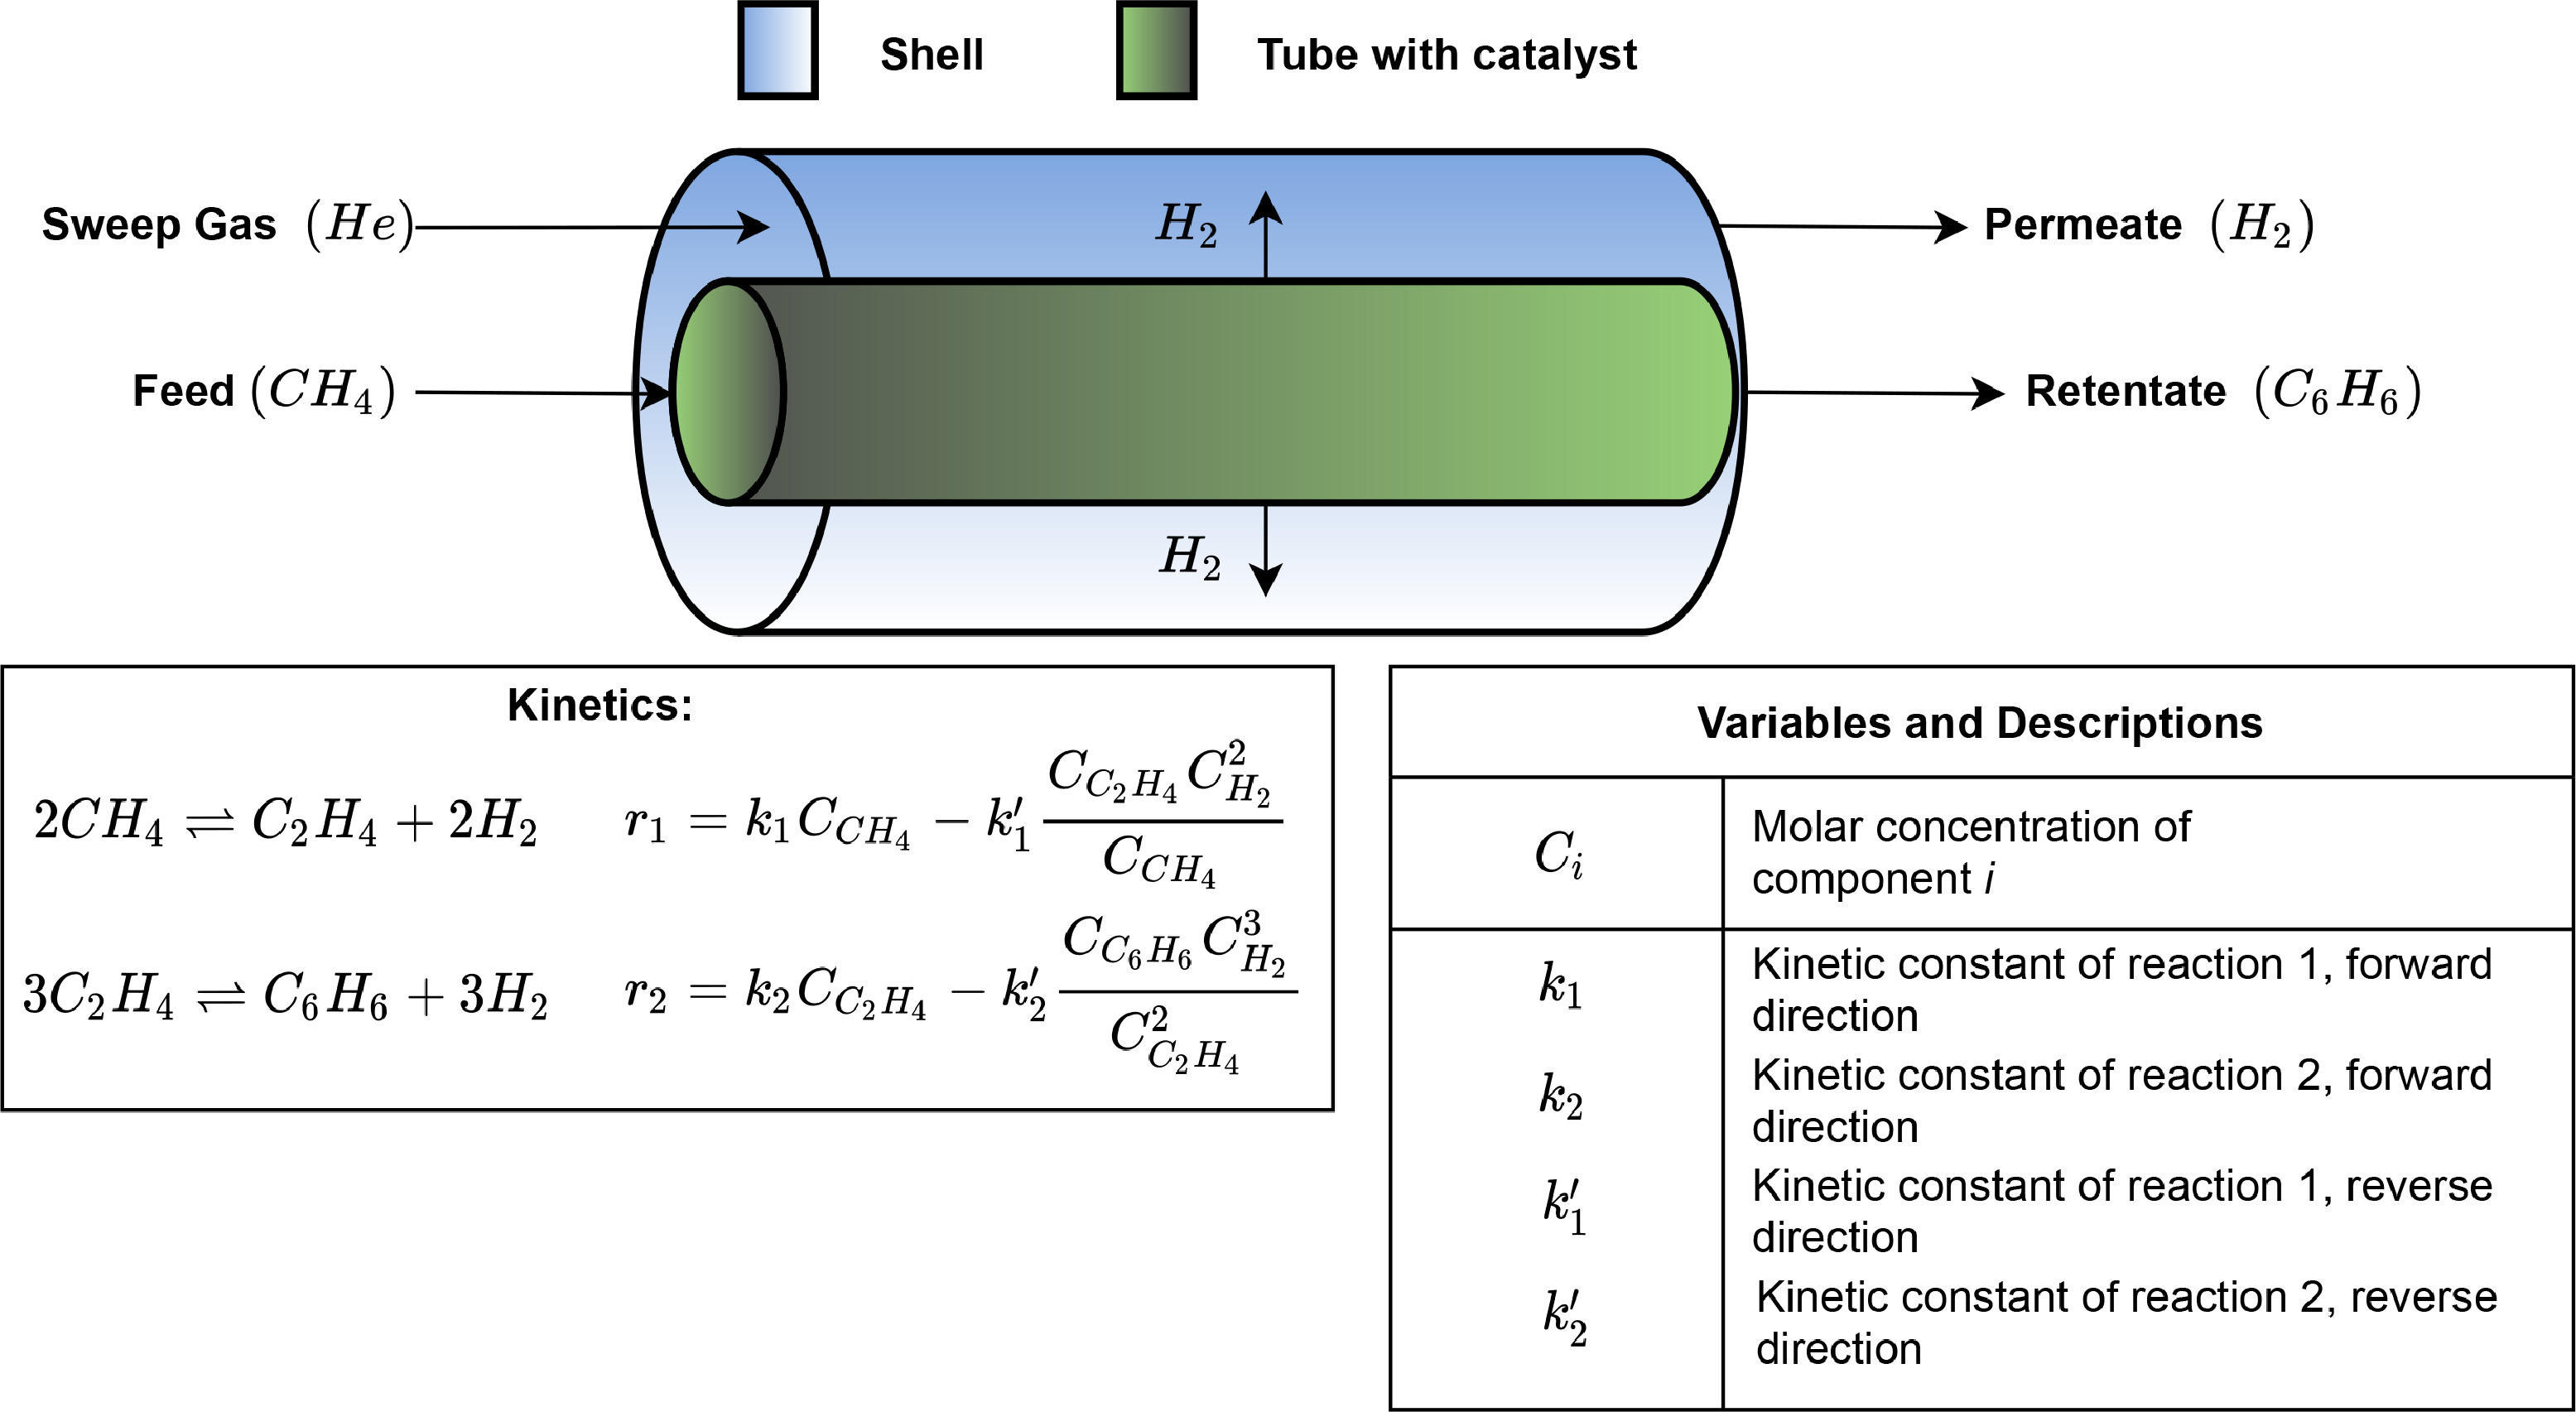

Reference: https://www.sciencedirect.com/science/article/pii/S0098135422001739

For this problem, we have considered two sides \
1. Tube Side \
2. Shell Side \


Tube side is where the reaction happens and shell side is the permeate side. Hydrogen being the smaller molecule sweeps through the pores of the membranes and thus we can see that the permeate is hydrogen rich and the retentate is benzene rich.

The process model for this problem can be defined with the help of the molar balance on the reactor.

### Molar balances inside the tube

$$ \frac{dF_{t,CH_4}}{dZ} = r_1*A_t - \frac{Q}{α_{H_2/CH_4}}*(P_{t,CH_4}^{1/4} - P_{s,CH_4}^{1/4})Πd_t $$

$$ \frac{dF_{t,C_2H_4}}{dZ} = -\frac{r_1}{2}*A_t + r_2*A_t - \frac{Q}{α_{H_2/C_2H_4}}*(P_{t,C_2H_4}^{1/4} - P_{s,C_2H_4}^{1/4})Πd_t $$

$$ \frac{dF_{t,H_2}}{dZ} = -r_1*A_t - r_2*A_t - Q*(P_{t,H_2}^{1/4} - P_{s,H_2}^{1/4})Πd_t $$

$$ \frac{dF_{t,C_6H_6}}{dZ} = \frac{r_1}{3}*A_t - \frac{Q}{α_{H_2/C_6H_6}}*(P_{t,C_6H_6}^{1/4} - P_{s,C_6H_6}^{1/4})Πd_t $$


### Molar balances inside the shell


$$ \frac{dF_{s,CH_4}}{dZ} = \frac{Q}{α_{H_2/CH_4}}*(P_{t,CH_4}^{1/4} - P_{s,CH_4}^{1/4})Πd_t $$

$$ \frac{dF_{s,C_2H_4}}{dZ} = \frac{Q}{α_{H_2/C_2H_4}}*(P_{t,C_2H_4}^{1/4} - P_{s,C_2H_4}^{1/4})Πd_t $$

$$ \frac{dF_{t,H_2}}{dZ} = Q*(P_{t,H_2}^{1/4} - P_{s,H_2}^{1/4})Πd_t $$

$$ \frac{dF_{t,C_6H_6}}{dZ} = \frac{Q}{α_{H_2/C_6H_6}}*(P_{t,C_6H_6}^{1/4} - P_{s,C_6H_6}^{1/4})Πd_t $$

Here, \
Q: $H_2$ permeance through the membrane \
$α_{H_2,i}$: selectivity between hydrogen and component 'i' \
$P_{t,i}$: Partial pressure of component i in feed \
$P_{s,i}$: Partial pressure of component i in permeate \

The two inputs that are considered for this problems are:
1. Tube Length
2. Tube Diameter

The two outputs that are considered are:
1. Methane Conversion ($X_{CH_4}$)
2. Benzene Flow ($F_{C_6H_6}$)

In [ ]:
%%capture
pip uninstall scipy

In [ ]:
%%capture
pip install scipy

In [ ]:
%%capture
!apt install coinor-libipopt-dev

In [ ]:
%%capture
!pip install ipopt

In [ ]:
from cyipopt import minimize_ipopt
from typing import Callable,Union

## Importing the required packages

In [ ]:
from scipy.stats import qmc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.optimize import root
from sklearn.neural_network import MLPRegressor

The two inputs that are considered for this problems are:
1. Tube Length
2. Tube Diameter

The two outputs that are considered are:
1. Methane Conversion ($X_{CH_4}$)
2. Benzene Flow ($F_{C_6H_6}$)

Now, we will follow the same six steps that we did for the shower problem.

## Step 1: Defining the bounds on the inputs

In [ ]:
lb = [10,0.1]
ub = [300,2]

### Step 2: Sampling

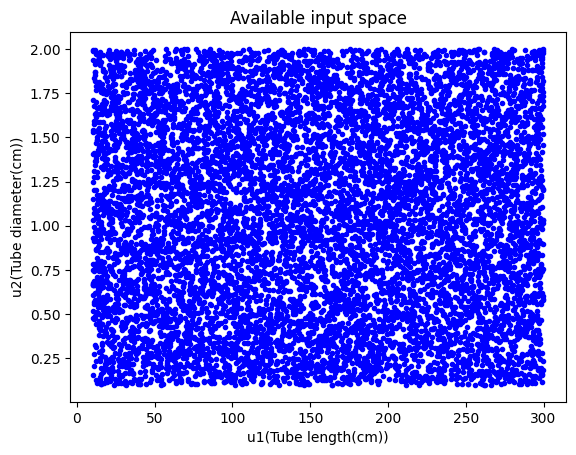

<Figure size 640x480 with 0 Axes>

In [ ]:
n = 10000
sampler = qmc.LatinHypercube(d = 2)
sample = sampler.random(n)
U = qmc.scale(sample,lb,ub)
u1 = U[:,0].flatten()
u2 = U[:,1].flatten()

# n = 40
# u2 = np.linspace(0.5, 2, n)        # Tube diameter [cm]
# u1 = np.linspace(10.00, 300.00, n)  # Tube length

# u2, u1 = np.meshgrid(u2, u1)         # Mesh

# u2 = u2.flatten()
# u1 = u1.flatten()
# U = np.array([u2,u1]).T


#Plot
plt.plot(u1, u2, 'b.')
plt.title('Available input space')
plt.ylabel('u2(Tube diameter(cm))')
plt.xlabel('u1(Tube length(cm))')
plt.figure();

In [ ]:
U.shape

(10000, 2)

### Step 3: Computing the output

In [ ]:
# Defining the parameters
# Kinetic  and general parameters
R = 8.314e6  #Pa.cm3/(K.mol)
k1 = 0.04  #1/s
k1i = 6.4e6  #cm3/s-mol
k2 = 4.2 #1/s
k2i = 56.38  #cm3/s-mol

# Molecular weight
M_B = 78  #g/mol


# Fixed Reactor Values
T = 1173.15  #K
Q = 3600*10**-6  #mol/(h.cm2.atm1/4)
alpha = 1500  #selectivity

# Tube sid
Pt = 101325.0  #atm pressure
v0 = 3600 * (2 / 15)  # cm3/hr
Ft0 = Pt * v0 / (R * T)  #mol/hr

# Shell side
Ps = 101325.0  #atm pressure
ds = 3  #cm
v_He = 3600 * (1 / 6)  # cm3/hr
F_He = Ps * v_He / (R * T)  #mol/hr

In [ ]:
def process_model(U):
  u1,u2 = U
  def dmamr(z,F):
    F0, F1, F2, F3, F4, F5, F6, F7 = F
    At = np.pi/4 * (u2**2)

    F0 = np.where(F0 <= 1e-9, 1e-9, F0)
    F1 = np.where(F1 <= 1e-9, 1e-9, F1)
    F2 = np.where(F2 <= 1e-9, 1e-9, F2)
    F3 = np.where(F3 <= 1e-9, 1e-9, F3)
    F4 = np.where(F4 <= 1e-9, 1e-9, F4)
    F5 = np.where(F5 <= 1e-9, 1e-9, F5)
    F6 = np.where(F6 <= 1e-9, 1e-9, F6)
    F7 = np.where(F7 <= 1e-9, 1e-9, F7)

    #volumetric flow rate changes because we are considering a gas phase reaction.
    Ftot_tube = F0 + F1 + F2 + F3
    Ftot_shell =  F4 + F5 + F6 + F7 + F_He
    v = v0*Ftot_tube/Ft0

    # Concentrations
    c0 = F0/v
    c1 = F1/v
    c2 = F2/v
    c3 = F3/v

    #Computing the partial pressures
    #P.P = Total Pressure * Mole Fraction

    #Tube Side
    p0t = (Pt/101325)*F0/Ftot_tube
    p1t = (Pt/101325)*F1/Ftot_tube
    p2t = (Pt/101325)*F2/Ftot_tube
    p3t = (Pt/101325)*F3/Ftot_tube

    #Shell Side
    p0s = (Ps/101325)*F4/Ftot_shell
    p1s = (Ps/101325)*F5/Ftot_shell
    p2s = (Ps/101325)*F6/Ftot_shell
    p3s = (Ps/101325)*F7/Ftot_shell

    #Defining the rates of reactions
    r1 = 3600*k1*c0*(1-((k1i*c1*c2**2)/(k1*c0**2)))
    r1 = np.where(c0<= 1e-9, 0, r1)
    r2 = 3600*k2*c1*(1-((k2i*c3*c2**3)/(k2*c1**3)))
    r2 = np.where(c1<= 1e-9, 0, r2)

    #Experimental values adjustment
    Ca1 = (1-0.5)*0.9

    #Molar balances of the reactor
    #Tube side
    df0dz = -r1 * Ca1 * At - (Q/alpha) * ((p0t**0.25) - (p0s**0.25)) * np.pi * u2
    df1dz = r1/2 * At * Ca1 - Ca1 * r2 * At - (Q/alpha) * ((p1t**0.25) - (p1s**0.25)) * np.pi * u2
    df2dz = r1 * Ca1 * At + Ca1 * r2 * At - (Q) * ((p2t)**0.25 - (p2s)**0.25) * np.pi * u2
    df3dz = Ca1 * r2/3 * At - (Q/alpha) * ((p3t)**0.25 - (p3s)**0.25) * np.pi * u2
    #Shell side
    df4dz = (Q/alpha) * ((p0t)**0.25 - (p0s)**0.25) * np.pi * u2
    df5dz = (Q/alpha) * ((p1t)**0.25 - (p1s)**0.25) * np.pi * u2
    df6dz = (Q) * ((p2t)**0.25 - (p2s)**0.25) * np.pi * u2
    df7dz = (Q/alpha) * ((p3t)**0.25 - (p3s)**0.25) * np.pi * u2

    return np.array([df0dz, df1dz, df2dz, df3dz, df4dz, df5dz, df6dz, df7dz])
  from scipy.integrate import solve_ivp
  y0 = np.array([Ft0, 0, 0, 0 ,0, 0, 0, 0])
  z = np.asarray([0,u1])
  sol = solve_ivp(dmamr, z, y0, method = 'RK45', rtol = 1e-9, atol = 1e-9)
  F_benzene = float((sol.y[3][-1] * 1000) * M_B)
  X_CH4 = float(100 * (Ft0 - sol.y[0][-1] - sol.y[4][-1]) / Ft0)
  return np.array([F_benzene, X_CH4])

In [ ]:
def sprocess_model(U):
  u1,u2 = U
  def dmamr(z,F):
    F0, F1, F2, F3, F4, F5, F6, F7 = F
    At = np.pi/4 * (u2**2)

    F0 = np.where(F0 <= 1e-9, 1e-9, F0)
    F1 = np.where(F1 <= 1e-9, 1e-9, F1)
    F2 = np.where(F2 <= 1e-9, 1e-9, F2)
    F3 = np.where(F3 <= 1e-9, 1e-9, F3)
    F4 = np.where(F4 <= 1e-9, 1e-9, F4)
    F5 = np.where(F5 <= 1e-9, 1e-9, F5)
    F6 = np.where(F6 <= 1e-9, 1e-9, F6)
    F7 = np.where(F7 <= 1e-9, 1e-9, F7)

    #volumetric flow rate changes because we are considering a gas phase reaction.
    Ftot_tube = F0 + F1 + F2 + F3
    Ftot_shell =  F4 + F5 + F6 + F7 + F_He
    v = v0*Ftot_tube/Ft0

    # Concentrations
    c0 = F0/v
    c1 = F1/v
    c2 = F2/v
    c3 = F3/v

    #Computing the partial pressures
    #P.P = Total Pressure * Mole Fraction

    #Tube Side
    p0t = (Pt/101325)*F0/Ftot_tube
    p1t = (Pt/101325)*F1/Ftot_tube
    p2t = (Pt/101325)*F2/Ftot_tube
    p3t = (Pt/101325)*F3/Ftot_tube

    #Shell Side
    p0s = (Ps/101325)*F4/Ftot_shell
    p1s = (Ps/101325)*F5/Ftot_shell
    p2s = (Ps/101325)*F6/Ftot_shell
    p3s = (Ps/101325)*F7/Ftot_shell

    #Defining the rates of reactions
    r1 = 3600*k1*c0*(1-((k1i*c1*c2**2)/(k1*c0**2)))
    r1 = np.where(c0<= 1e-9, 0, r1)
    r2 = 3600*k2*c1*(1-((k2i*c3*c2**3)/(k2*c1**3)))
    r2 = np.where(c1<= 1e-9, 0, r2)

    #Experimental values adjustment
    Ca1 = (1-0.5)*0.9

    #Molar balances of the reactor
    #Tube side
    df0dz = -r1 * Ca1 * At - (Q/alpha) * ((p0t**0.25) - (p0s**0.25)) * np.pi * u2
    df1dz = r1/2 * At * Ca1 - Ca1 * r2 * At - (Q/alpha) * ((p1t**0.25) - (p1s**0.25)) * np.pi * u2
    df2dz = r1 * Ca1 * At + Ca1 * r2 * At - (Q) * ((p2t)**0.25 - (p2s)**0.25) * np.pi * u2
    df3dz = Ca1 * r2/3 * At - (Q/alpha) * ((p3t)**0.25 - (p3s)**0.25) * np.pi * u2
    #Shell side
    df4dz = (Q/alpha) * ((p0t)**0.25 - (p0s)**0.25) * np.pi * u2
    df5dz = (Q/alpha) * ((p1t)**0.25 - (p1s)**0.25) * np.pi * u2
    df6dz = (Q) * ((p2t)**0.25 - (p2s)**0.25) * np.pi * u2
    df7dz = (Q/alpha) * ((p3t)**0.25 - (p3s)**0.25) * np.pi * u2

    return np.array([df0dz, df1dz, df2dz, df3dz, df4dz, df5dz, df6dz, df7dz])
  from scipy.integrate import solve_ivp
  y0 = np.array([Ft0, 0, 0, 0 ,0, 0, 0, 0])
  z = np.asarray([0,u1])
  sol = solve_ivp(dmamr, z, y0, method = 'LSODA', rtol = 1e-9, atol = 1e-9)
  F_benzene = float((sol.y[3][-1] * 1000) * M_B)
  X_CH4 = float(100 * (Ft0 - sol.y[0][-1] - sol.y[4][-1]) / Ft0)
  return np.array([F_benzene, X_CH4])

In [ ]:
y1 = np.zeros(U.shape[0])
y2 = np.zeros(U.shape[0])

for i in range(U.shape[0]):
  #print(i, U[i])
  y1[i] = sprocess_model(U[i])[0]
  y2[i] = sprocess_model(U[i])[1]
  #print(y1[i],y2[i])

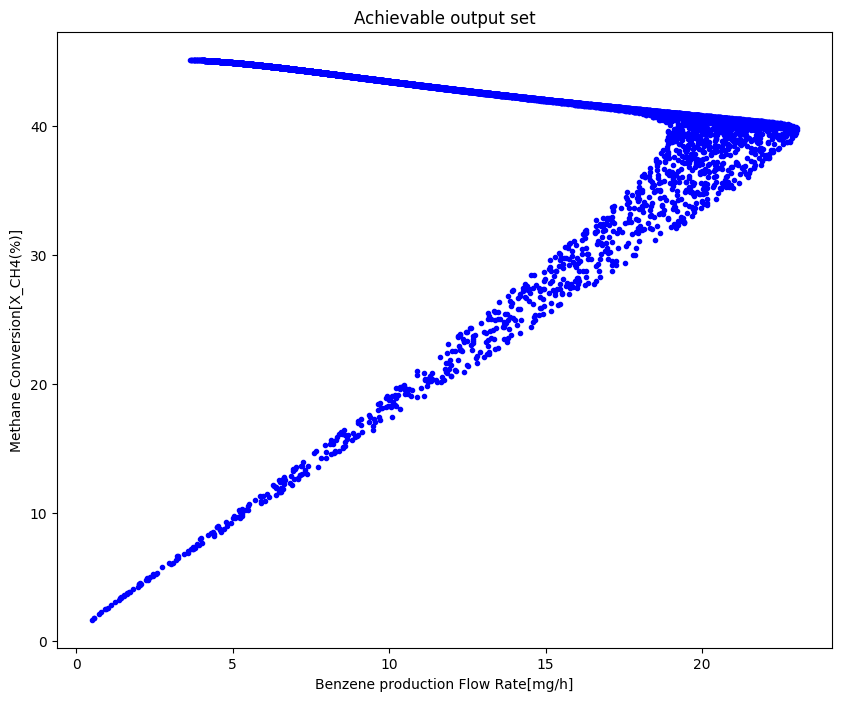

In [ ]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(y1, y2,'b.')
plt.xlabel('Benzene production Flow Rate[mg/h]')
plt.ylabel('Methane Conversion[X_CH4(%)]')
plt.title('Achievable output set');

### Step 4: Fitting the Neural Network

In [ ]:
X = U
y = np.array([y1,y2]).T
scaler = StandardScaler()
Model = MLPRegressor(hidden_layer_sizes =(20,20,20,) ,
                     activation = 'tanh',
                     alpha = 0.11,
                     solver = 'lbfgs',
                     max_iter=10000,
                     random_state = 23)
pipe = Pipeline([('scale', scaler),
                 ('model', Model)])
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                                        test_size=0.25,
                                                        shuffle=True,
                                                        random_state=0)
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
mae = mean_absolute_error(predictions, y_test)
rmse = mean_squared_error(predictions,y_test)
r2 = r2_score(predictions, y_test)
print(f'The mean absolute error for the test data is {mae:.2}')
print(f'The root mean square error for the test data is {rmse:.2}')
print(f'The R2 score for the test data is {r2:.8}')

The mean absolute error for the test data is 0.011
The root mean square error for the test data is 0.00041
The R2 score for the test data is 0.99998564


### Step 5: Evaluating the performance of Neural Network

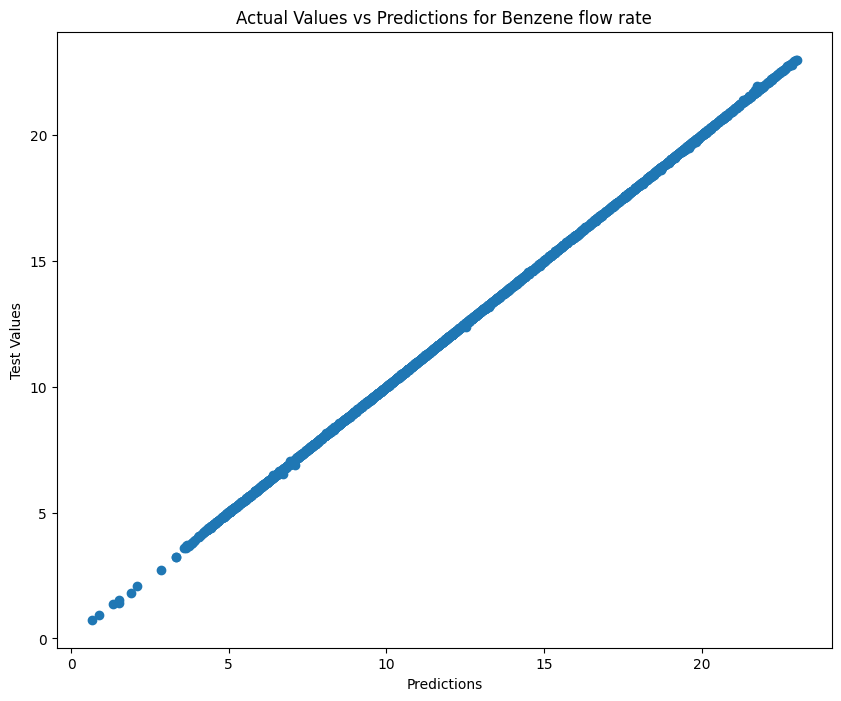

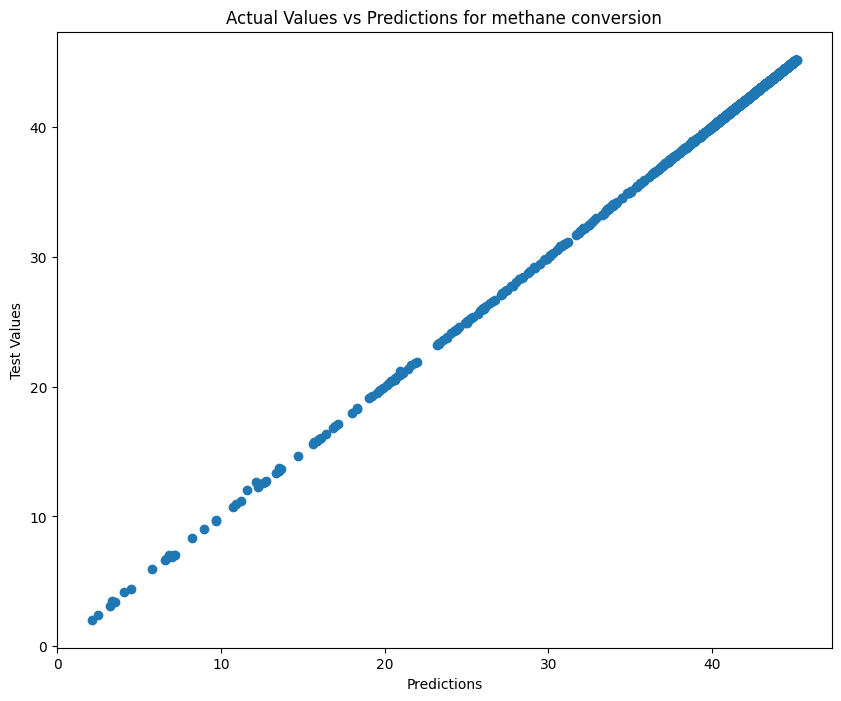

In [ ]:
y1hat = predictions[:,0]
y2hat = predictions[:,1]
y1_test = y_test[:,0]
y2_test = y_test[:,1]

plt.scatter(y1hat,y1_test)
plt.xlabel('Predictions')
plt.ylabel('Test Values')
plt.title('Actual Values vs Predictions for Benzene flow rate')
plt.show();

plt.scatter(y2_test,y2hat)
plt.xlabel('Predictions')
plt.ylabel('Test Values')
plt.title('Actual Values vs Predictions for methane conversion');
plt.show();

We can see that the fit is accurate as most of the points lie on the $45^o$ line, indicating an almost accurate fit. This fit was obtained with 3 layers and 20 neurons in each layer

### Step 6: Process Operability Analysis

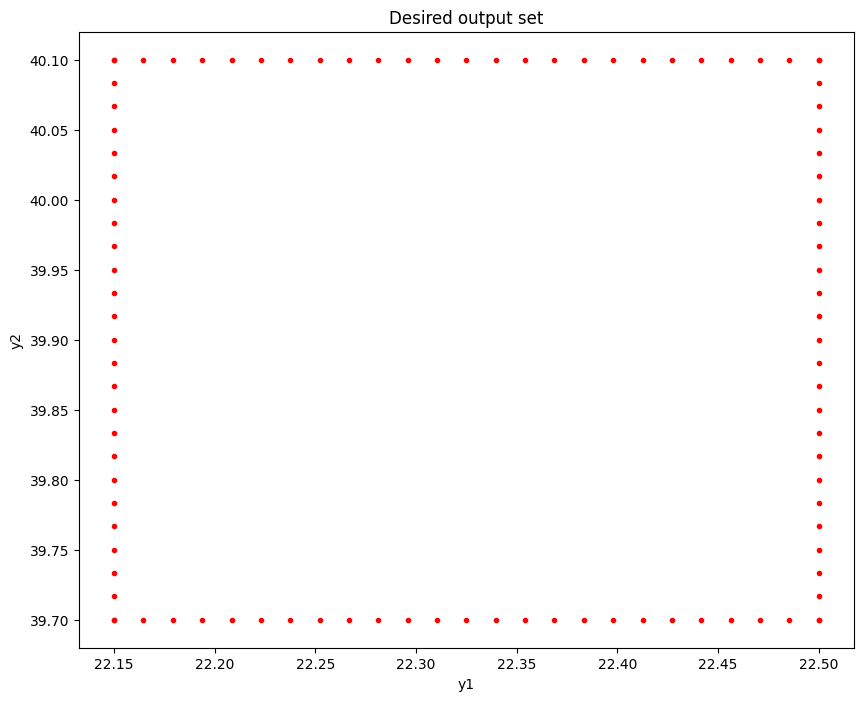

In [ ]:
lb = np.array([10, 0.5])
ub = np.array([300, 2])
u0 = np.array([50, 1])

dos_l = np.linspace(22.15,22.5,25)
dos_u = np.linspace(39.7,40.1, 25)
y1_dos = np.concatenate([dos_l, dos_l.max()*np.ones_like(dos_u), dos_l[::-1], dos_l.min() * np.ones_like(dos_u)])
y2_dos = np.concatenate([dos_u.min() * np.ones_like(dos_l), dos_u, dos_u.max() * np.ones_like(dos_l), dos_u[::-1]])
dos = np.array([y1_dos,y2_dos]).T

# lb = np.array([0, 0.5])
# ub = np.array([300, 2])
# u0 = np.array([50, 1])



# p = 22.6, 39.7
# r = 0.3

# theta = np.linspace(0, 2 * np.pi, 100)
# pX = r*np.sin(theta) + p[0]
# pY = r*np.cos(theta) + p[1]

# dos = np.asarray([pX, pY]).T

# dos_lb = [22.3, 39.7]
# dos_up = [22.5,40.1]
# DOS = 20 #number of datapoints
# dos_sampler = qmc.LatinHypercube(d = 2)
# sample_dos = dos_sampler.random(DOS)
# dos = qmc.scale(sample_dos,dos_lb, dos_up)

plt.plot(dos[:,0], dos[:,1], 'r.')
plt.ylabel('y2')
plt.xlabel('y1')
plt.title('Desired output set');

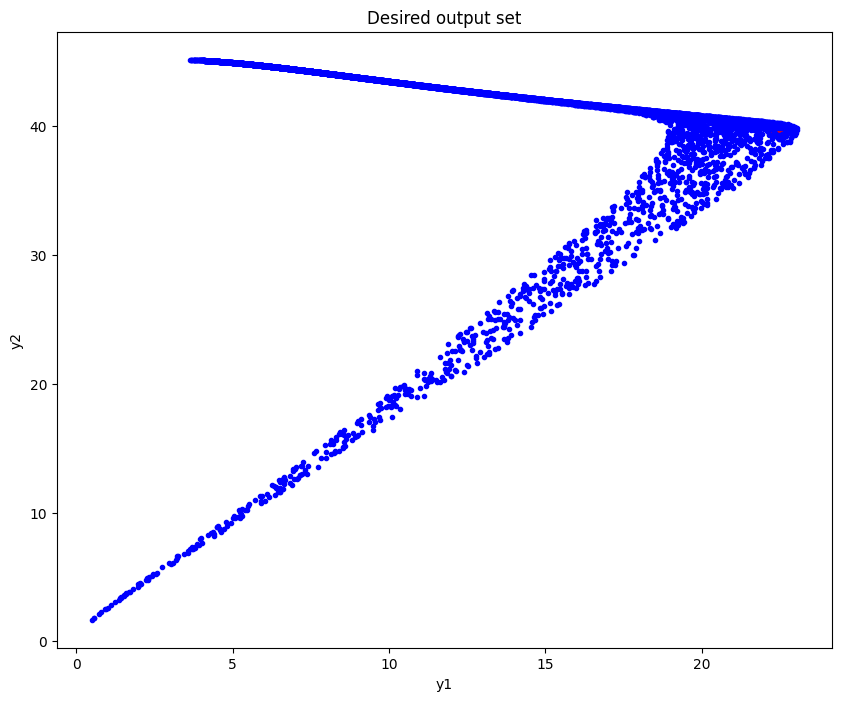

In [ ]:
plt.plot(dos[:,0], dos[:,1], 'r.')
plt.plot(y[:, 0], y[:, 1],'b.')
# plt.plot(pipe.predict(U)[:,0],pipe.predict(U)[:,1], 'g*')
plt.ylabel('y2')
plt.xlabel('y1')
plt.title('Desired output set');

In [ ]:
def Model(U:np.ndarray):
  U = U.reshape(1,-1)
  predictions = pipe.predict(U)
  return predictions.flatten()

In [ ]:
def nlp_based_approach(DOSPts: np.ndarray,
                       model: Callable[...,Union[float,np.ndarray]],
                       u0: np.ndarray,
                       lb: np.ndarray,
                       ub: np.ndarray,
                       constr=None) -> Union[np.ndarray,np.ndarray,list]:

    # Initialization of variables
    m = len(u0)
    r,c = np.shape(DOSPts)
    fDOS = np.zeros((r,c))
    fDIS = np.zeros((r,m))
    message_list = []
    bounds =  np.column_stack((lb,ub))

    # If unbounded, set as +-inf.
    if lb.size == 0:
        lb = -np.inf
    if ub.size == 0:
        ub = np.inf


    # Inverse-mapping: Run for each DOS grid point
    for i in range(r):

        sol = minimize_ipopt(p1, x0=u0,bounds=bounds,
                                     args=(model, DOSPts[i,:]))

        fDOS[i,:] = model(sol.x)
        fDIS[i,:] = sol.x
        message_list.append(sol.message)
        print(i)


    return fDIS, fDOS, message_list


# Objective function (Problem type I)
def p1(u: np.ndarray,
       model:Callable[...,Union[float,np.ndarray]],
       DOSpt: np.ndarray):

    y_found = np.zeros(DOSpt.shape)
    y_found = model(u)

    f =  np.sum(list(map(error, y_found, DOSpt)))

    return f

# Error minimization function
def error(yf,yd):
    return ((yf-yd)/yd)*((yf-yd)/yd)

lb = np.array([10, 0.5])
ub = np.array([300, 2])
u0 = np.array([50, 1])

fDIS_sm, fDOS_sm, message_list_sm = nlp_based_approach(dos, Model, u0, lb,ub,constr=None)

u1sm = fDIS_sm[:,0]
u2sm = fDIS_sm[:,1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


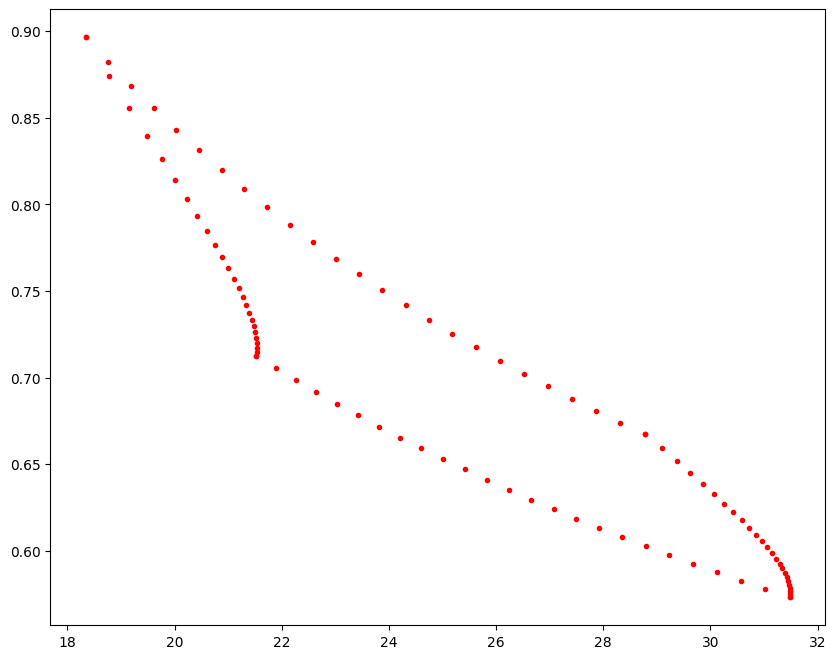

In [ ]:
plt.plot(u1sm,u2sm,'r.')

### Comparison of this result with NLP-based approach using the process model

In [ ]:
lb = np.array([10, 0.5])
ub = np.array([300, 2])
u0 = np.array([50, 1])

fDIS, fDOS, message_list = nlp_based_approach(dos, process_model, u0, lb,ub,constr=None)

u1nlp = fDIS[:,0]
u2nlp = fDIS[:,1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


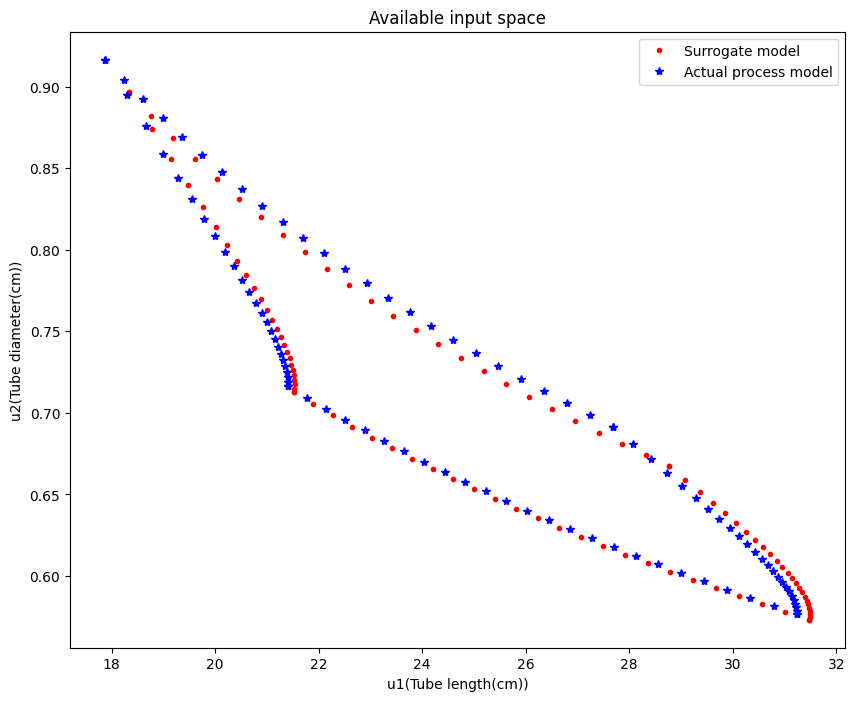

In [ ]:
plt.plot(u1sm, u2sm, 'r.', label = 'Surrogate model')
plt.plot(u1nlp, u2nlp, 'b*', label = 'Actual process model')
plt.title('Available input space')
plt.ylabel('u2(Tube diameter(cm))')
plt.xlabel('u1(Tube length(cm))')
plt.legend();

In [ ]:
u1error = np.sum(abs(u1sm-u1nlp)/u1sm*100)/(dos.shape[0])
u2error = np.sum(abs(u2sm-u2nlp)/u2sm*100)/(dos.shape[0])
print(f'The error in the prediction of u1 using the proposed approach is {u1error:.2}%')
print(f'The error in the prediction of u2 using the proposed approach is {u2error:.2}%')

The error in the prediction of u1 using the proposed approach is 1.9%
The error in the prediction of u2 using the proposed approach is 1.8%
